In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors
from scipy.signal import resample_poly

In [2]:
scd_data = {
 './data/scddb/30': '07:54:33',
 './data/scddb/31': '13:42:24',
 './data/scddb/32': '16:45:18',
 './data/scddb/33': '04:46:19',
 './data/scddb/34': '06:35:44',
 './data/scddb/35': '24:34:56',
 './data/scddb/36': '18:59:01',
 './data/scddb/37': '01:31:13',
 './data/scddb/38': '08:01:54',
 './data/scddb/39': '04:37:51',
 './data/scddb/41': '02:59:24',
 './data/scddb/43': '15:37:11',
 './data/scddb/44': '19:38:45',
 './data/scddb/45': '18:09:17',
 './data/scddb/46': '03:41:47',
 './data/scddb/47': '06:13:01',
 './data/scddb/48': '02:29:40',
 './data/scddb/50': '11:45:43',
 './data/scddb/51': '22:58:23',
 './data/scddb/52': '02:32:40'}

In [3]:
fs=250

In [4]:
def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def extract_before_onset_VF(vfon_dict, minutes_before=30):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 30-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

def segment_ecg(ecg_segment, segment_duration_sec=300, fs=250):
    samples_per_segment = segment_duration_sec * fs
    segments = np.array_split(ecg_segment, len(ecg_segment) // samples_per_segment)
    return segments

In [5]:
onsetVF_30min_scd = extract_before_onset_VF(scd_data, minutes_before=30)
onset30_6segments_5mins = segment_ecg(onsetVF_30min_scd['30'])
first_5min_of30 = onset30_6segments_5mins[5]

[OK] Extracted 30-min for 30: shape=(450000,)
[OK] Extracted 30-min for 31: shape=(450000,)
[OK] Extracted 30-min for 32: shape=(450000,)
[OK] Extracted 30-min for 33: shape=(450000,)
[OK] Extracted 30-min for 34: shape=(450000,)
[OK] Extracted 30-min for 35: shape=(450000,)
[OK] Extracted 30-min for 36: shape=(450000,)
[OK] Extracted 30-min for 37: shape=(450000,)
[OK] Extracted 30-min for 38: shape=(450000,)
[OK] Extracted 30-min for 39: shape=(450000,)
[OK] Extracted 30-min for 41: shape=(450000,)
[OK] Extracted 30-min for 43: shape=(450000,)
[OK] Extracted 30-min for 44: shape=(450000,)
[OK] Extracted 30-min for 45: shape=(450000,)
[OK] Extracted 30-min for 46: shape=(450000,)
[OK] Extracted 30-min for 47: shape=(450000,)
[OK] Extracted 30-min for 48: shape=(450000,)
[OK] Extracted 30-min for 50: shape=(450000,)
[OK] Extracted 30-min for 51: shape=(450000,)
[OK] Extracted 30-min for 52: shape=(450000,)


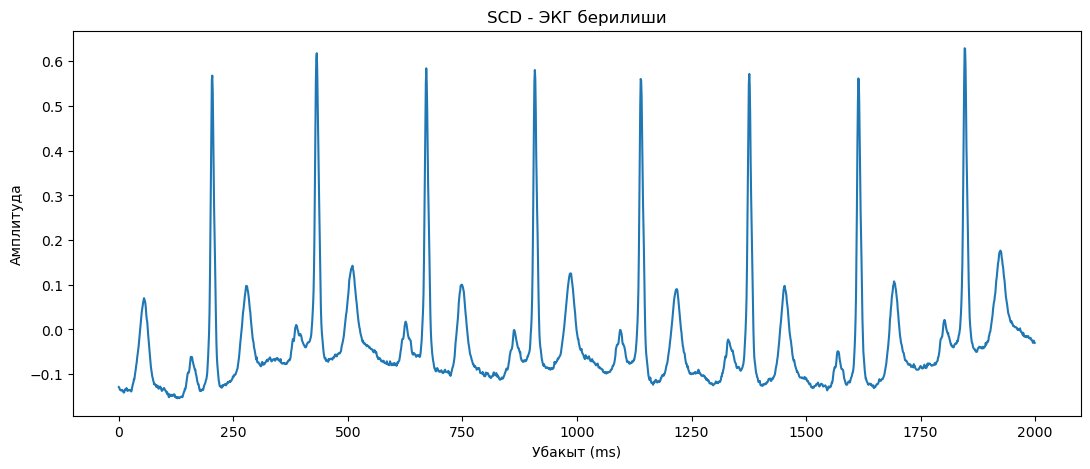

In [12]:
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(first_5min_of30[2000:4000])
plt.title('SCD - ЭКГ берилиши')
plt.xlabel('Убакыт (ms)')
plt.ylabel('Амплитуда')
plt.savefig('./img/scd_example.png', dpi=300, bbox_inches='tight')
plt.show()

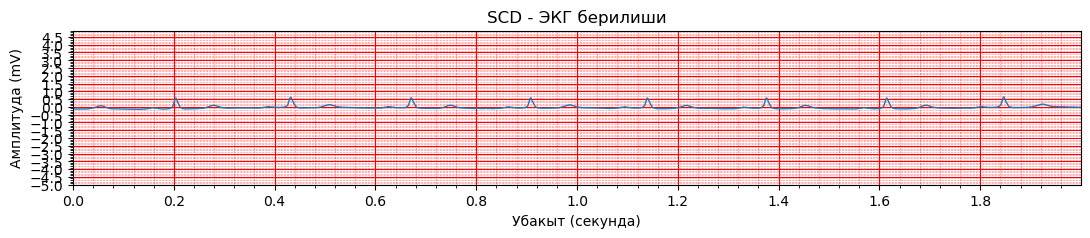

In [19]:
ecg_data = first_5min_of30[2000:4000]
time = np.arange(len(ecg_data)) * 0.001  # Assuming 1000 Hz sample rate (1 ms between samples)

plt.figure(figsize=(13, 2))
ax = plt.gca()

# Plot ECG signal
ax.plot(time, ecg_data, linewidth=1.0)

# Grid settings (simulate ECG paper)
ax.set_xlim(time[0], time[-1])
ax.set_ylim(min(ecg_data)-0.5, max(ecg_data)+0.5)

# Minor grid (small squares)
ax.set_xticks(np.arange(time[0], time[-1], 0.04), minor=True)  # 0.04 s
ax.set_yticks(np.arange(-5, 5, 0.1), minor=True)  # 0.1 mV

# Major grid (large squares)
ax.set_xticks(np.arange(time[0], time[-1], 0.2))  # 0.2 s
ax.set_yticks(np.arange(-5, 5, 0.5))  # 0.5 mV

# Style the grid to look like ECG paper
ax.grid(which='major', color='red', linewidth=0.8)
ax.grid(which='minor', color='red', linestyle=':', linewidth=0.4)

# Labels and title
ax.set_title('SCD - ЭКГ берилиши')
ax.set_xlabel('Убакыт (секунда)')
ax.set_ylabel('Амплитуда (mV)')

# Save the figure (optional)
plt.savefig('ecg_paper_plot.png', dpi=300, bbox_inches='tight')
plt.show()

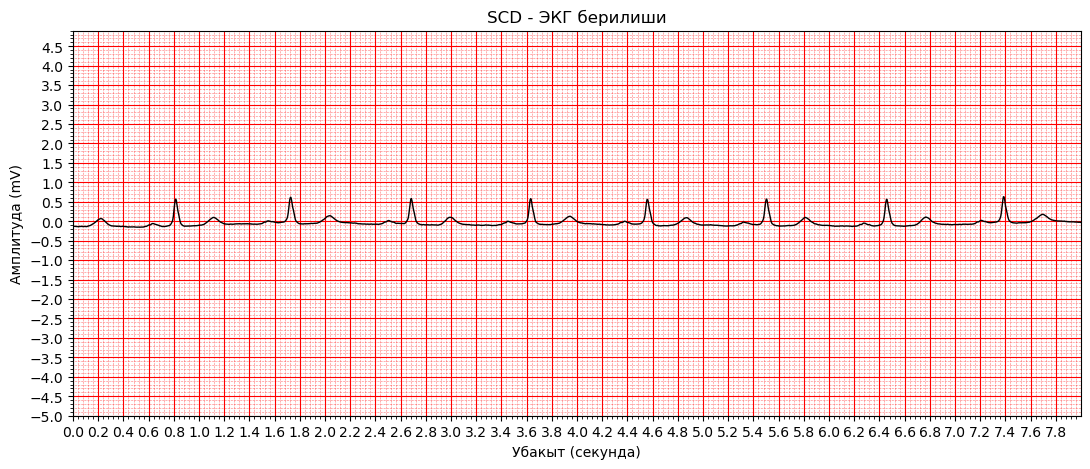

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming first_5min_of30 is your ECG data
ecg_data = first_5min_of30[2000:4000]
fs = 250  # Sampling frequency in Hz
time = np.arange(len(ecg_data)) / fs  # Time axis in seconds

plt.figure(figsize=(13, 5))
ax = plt.gca()

# Plot the ECG signal
ax.plot(time, ecg_data, linewidth=1.0, color='black')

# Set axis limits
ax.set_xlim(time[0], time[-1])
ax.set_ylim(min(ecg_data) - 0.5, max(ecg_data) + 0.5)

# Minor grid every 0.04 seconds (10 samples)
ax.set_xticks(np.arange(time[0], time[-1], 0.04), minor=True)
ax.set_yticks(np.arange(-5, 5, 0.1), minor=True)

# Major grid every 0.2 seconds (50 samples)
ax.set_xticks(np.arange(time[0], time[-1], 0.2))
ax.set_yticks(np.arange(-5, 5, 0.5))

# Red ECG paper-style grid
ax.grid(which='major', color='red', linewidth=0.8)
ax.grid(which='minor', color='red', linestyle=':', linewidth=0.4)

# Add labels and title
ax.set_title('SCD - ЭКГ берилиши')
ax.set_xlabel('Убакыт (секунда)')
ax.set_ylabel('Амплитуда (mV)')

# Save high-quality figure
plt.savefig('./img/ecg_paper_250Hz.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np

pre_event_sec_1 = 60 * 5  # 1 minute
pre_event_samples_1 = int(pre_event_sec_1 * fs)

start_idx_1 = max(0, ex_1 - pre_event_samples_1)
end_idx_1 = ex_1  # up to the VF onset

ecg_segment_1 = record.p_signal[start_idx_1+60000:ex_1+3000, :]  # shape (samples, 2) if 2 channels

print(f"Extracted a {pre_event_sec_1}-second segment before VF onset.")

plt.figure(figsize=(20, 5))
plt.subplot()
plt.plot(ecg_segment_1[:,0])
plt.title('Original NSR Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()